### Assignment 3: Performance Measures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
industry = pd.read_csv('Industry_Portfolios.csv', index_col=0)
market = pd.read_csv('Market_Portfolio.csv', index_col=0)
risk = pd.read_csv('Risk_Factors.csv', index_col=0)

industry.index = pd.to_datetime(industry.index, format='%Y%m').to_period('M')
market.index = pd.to_datetime(market.index, format='%Y%m').to_period('M')
risk.index = pd.to_datetime(risk.index, format='%Y%m').to_period('M')

risk.head()

,Rf,Rm-Rf,SMB,HML
Date,,,,
2004-01,0.07,2.15,2.67,1.55
2004-02,0.06,1.40,-1.17,0.45
2004-03,0.09,-1.32,1.84,0.07
2004-04,0.08,-1.83,-2.59,-1.67
2004-05,0.06,1.17,-0.10,-0.33


In [22]:
from sklearn.linear_model import LinearRegression

risk_free_rate = risk['Rf']

# Calculate excess returns by subtracting the risk-free rate from the market and industry returns
market['Excess Market Return'] = market['Market'] - risk_free_rate
industry_portfolios_df_excess = industry.copy()
industry_columns = industry_portfolios_df_excess.columns  # Excluding the 'Date' column

for col in industry_columns:
    industry_portfolios_df_excess[col] = industry_portfolios_df_excess[col] - risk_free_rate

# Prepare to run regressions for each industry portfolio
results = []

# Running regression: Regressing each industry's excess returns on the market's excess returns
for col in industry_columns:
    # Create regression model
    reg = LinearRegression()
    
    # Prepare data for regression
    X = market['Excess Market Return'].values.reshape(-1, 1)  # Independent variable (market excess returns)
    y = industry_portfolios_df_excess[col].values  # Dependent variable (industry excess returns)
    
    # Fit the model
    reg.fit(X, y)
    
    # Store the intercept (α) and slope (β)
    alpha = reg.intercept_
    beta = reg.coef_[0]
    
    # Append the results to a list
    results.append({'Industry': col, 'Alpha (Intercept)': alpha, 'Beta (Slope)': beta})

# Convert results to DataFrame for better display
results_df = pd.DataFrame(results).set_index('Industry')

round(results_df, 3)

,Alpha (Intercept),Beta (Slope)
Industry,,
NoDur,0.370,0.654
Durbl,-0.418,1.649
Manuf,0.160,1.168
Enrgy,0.504,0.966
HiTec,-0.064,1.132
Telcm,0.194,0.902
Shops,0.274,0.830
Hlth,0.237,0.676
Utils,0.447,0.537


In [23]:
import statsmodels.api as sm

# Assuming excess_returns is the DataFrame with the excess returns of each industry portfolio
# risk_factors contains 'Market Risk Premium', 'SMB', and 'HML'

# Prepare the Fama-French factor matrix (add constant for alpha)
X = sm.add_constant(risk[['Rm-Rf', 'SMB', 'HML']])

# Perform regression for each industry portfolio
factor_loadings = {}
for portfolio in industry_portfolios_df_excess.columns:
    y = industry_portfolios_df_excess[portfolio]
    model = sm.OLS(y, X).fit()
    factor_loadings[portfolio] = model.params  # Extract the coefficients (loadings)

# Convert to DataFrame for easy analysis
factor_loadings_df = pd.DataFrame(factor_loadings).T
factor_loadings_df.columns = ['Alpha', 'Beta_MKT', 'Beta_SMB', 'Beta_HML']

round(factor_loadings_df,3)


,Alpha,Beta_MKT,Beta_SMB,Beta_HML
NoDur,0.387,0.712,-0.229,-0.023
Durbl,-0.474,1.447,0.671,0.241
Manuf,0.153,1.142,0.087,0.028
Enrgy,0.523,1.028,-0.259,-0.008
HiTec,-0.066,1.153,0.336,-0.557
Telcm,0.201,0.924,-0.080,-0.019
Shops,0.256,0.770,0.280,-0.039
Hlth,0.257,0.752,-0.213,-0.144
Utils,0.474,0.632,-0.388,-0.017
Other,-0.404,1.123,-0.062,0.547


In [26]:
# Initialize a DataFrame to store the performance metrics
performance_metrics = pd.DataFrame(index=industry.columns, columns=['Sharpe Ratio', 'Sortino Ratio', 'Treynor Ratio', "Jensen's Alpha", "Three-Factor Alpha"])

# Calculate excess returns
excess_returns = industry.sub(risk['Rf'], axis=0)

# Sharpe Ratio
performance_metrics['Sharpe Ratio'] = excess_returns.mean() / excess_returns.std()

# Sortino Ratio (Mean of excess returns / Semi-variance)
semi_variance = ((excess_returns[excess_returns < 0] ** 2).mean())
performance_metrics['Sortino Ratio'] = excess_returns.mean() / np.sqrt(semi_variance)

# Treynor Ratio (Mean of excess returns / Beta, using CAPM beta)
beta = results_df['Beta (Slope)']
performance_metrics['Treynor Ratio'] = excess_returns.mean() / beta

# Jensen's Alpha (Excess returns - (Rf + Beta * Market Excess Return))
market_excess_return = risk['Rm-Rf']
performance_metrics["Jensen's Alpha"] = excess_returns.mean() - (beta * market_excess_return.mean())

# Three-Factor Alpha (similar to Jensen's alpha but adjusting for Fama-French factors)
factor_loadings = factor_loadings_df # Fama-French three-factor loadings (market, SMB, HML)
performance_metrics["Three-Factor Alpha"] = (
    excess_returns.mean()
    - (beta * market_excess_return.mean() 
    + factor_loadings['Beta_SMB'] * risk['SMB'].mean() 
    + factor_loadings['Beta_HML'] * risk['HML'].mean())
)

round(performance_metrics,3)

,Sharpe Ratio,Sortino Ratio,Treynor Ratio,Jensen's Alpha,Three-Factor Alpha
NoDur,0.231,0.212,1.186,0.370,0.423
Durbl,0.072,0.074,0.367,-0.418,-0.600
Manuf,0.167,0.144,0.758,0.160,0.137
Enrgy,0.182,0.168,1.143,0.504,0.562
HiTec,0.119,0.111,0.564,-0.064,-0.053
Telcm,0.169,0.152,0.836,0.194,0.215
Shops,0.192,0.179,0.951,0.274,0.219
Hlth,0.173,0.176,0.971,0.237,0.305
Utils,0.211,0.157,1.452,0.447,0.533
Other,0.065,0.055,0.300,-0.388,-0.456


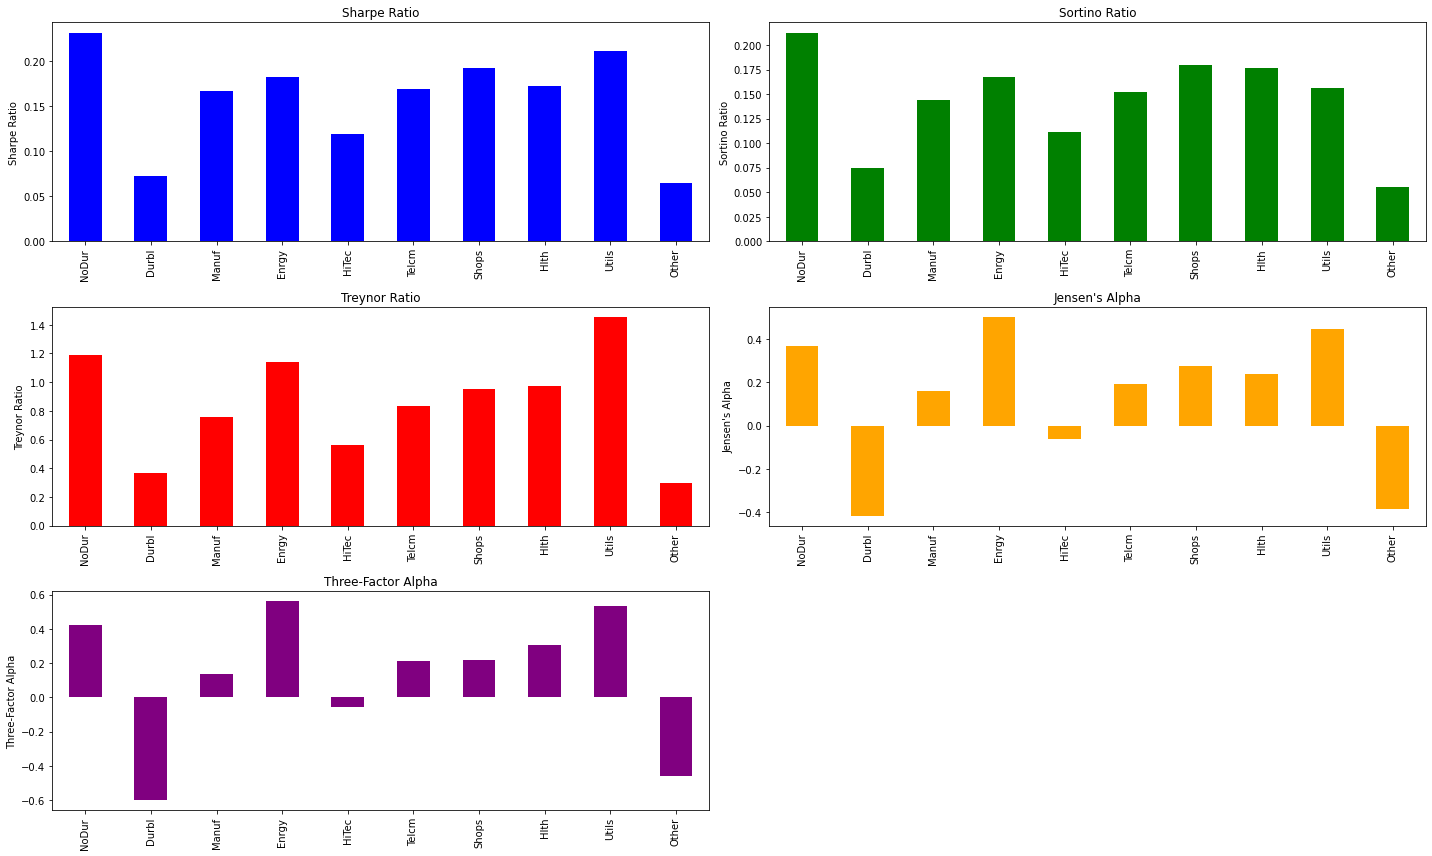

In [35]:
# List of performance metrics to plot
metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Treynor Ratio', "Jensen's Alpha", "Three-Factor Alpha"]

# Set up the number of rows and columns for the subplots
n_metrics = len(metrics)
n_cols = 2  # Use 2 columns for the subplots
n_rows = (n_metrics + 1) // n_cols  # Calculate the number of rows needed

# Set up colors for each metric
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Plot each metric with consistent y-axis limits
for i, metric in enumerate(metrics):
    performance_metrics[metric].plot(kind='bar', ax=axes[i], color=colors[i], title=metric)
    axes[i].set_ylabel(metric)

# Hide any extra subplots if there are fewer metrics than the grid's total spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make plots look neat and compact
plt.tight_layout()
plt.show()


1. Sharpe Ratio

    The Sharpe ratio measures the risk-adjusted return of a portfolio. It shows how much excess return (over the risk-free rate) is earned per unit of total risk (volatility). A higher Sharpe ratio indicates that the portfolio delivers better returns for the risk taken, making it a useful tool for comparing different investments.

    Pricing Implications: Investments with higher Sharpe ratios are more attractive to investors, as they offer better compensation for risk. In pricing terms, a high Sharpe ratio suggests the asset is well-priced for its risk, while a low or negative Sharpe ratio could indicate that the investment is either too risky for the return offered or overpriced.



2. Sortino Ratio

    The Sortino ratio focuses on downside risk, measuring returns relative to only the negative volatility (as opposed to total volatility). It is particularly useful for risk-averse investors who are more concerned with avoiding losses than achieving higher returns.

    Pricing Implications: A higher Sortino ratio indicates that the portfolio generates good returns without exposing the investor to significant downside risk. In pricing terms, assets with higher Sortino ratios might be considered safer or more efficiently priced in terms of downside protection, which can make them appealing to conservative investors.
    


3. Treynor Ratio

    The Treynor ratio measures the portfolio's excess return relative to systematic risk, as represented by its beta (sensitivity to market movements). It evaluates how well the portfolio compensates investors for market-related risk.
    
    Pricing Implications: A higher Treynor ratio suggests that the portfolio is delivering superior returns given its exposure to market risk. This could indicate that the asset is underpriced relative to its risk, making it attractive to investors. Conversely, a low Treynor ratio might indicate that the portfolio’s returns are insufficient for the amount of market risk taken, implying it could be overpriced.